# Demo EfficientLoFTR on a single pair of images

This notebook shows how to use the eloftr matcher with different model type and numerical precision on the pretrained weights.

In [4]:
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from ext_repos.EfficientLoFTR.src.utils.plotting import make_matching_figure

## Outdoor Example

We recommend using our pre-trained model for input in outdoor environments because our model has only been trained on MegaDepth, and there exists a domain gap between indoor and outdoor data.

In [5]:
from ext_repos.EfficientLoFTR.src.loftr import LoFTR, full_default_cfg, opt_default_cfg, reparameter

# You can choose model type in ['full', 'opt']
model_type = "full"  # 'full' for best quality, 'opt' for best efficiency

# You can choose numerical precision in ['fp32', 'mp', 'fp16']. 'fp16' for best efficiency
precision = "fp32"  # Enjoy near-lossless precision with Mixed Precision (MP) / FP16 computation if you have a modern GPU (recommended NVIDIA architecture >= SM_70).

# You can also change the default values like thr. and npe (based on input image size)

if model_type == "full":
    _default_cfg = deepcopy(full_default_cfg)
elif model_type == "opt":
    _default_cfg = deepcopy(opt_default_cfg)

if precision == "mp":
    _default_cfg["mp"] = True
elif precision == "fp16":
    _default_cfg["half"] = True

print(_default_cfg)
matcher = LoFTR(config=_default_cfg)

matcher.load_state_dict(torch.load("/kaggle/ext_repos/EfficientLoFTR/eloftr_outdoor.ckpt")["state_dict"])
matcher = reparameter(matcher)  # no reparameterization will lead to low performance

if precision == "fp16":
    matcher = matcher.half()

matcher = matcher.eval().cuda()

{'backbone_type': 'RepVGG', 'align_corner': False, 'resolution': (8, 1), 'fine_window_size': 8, 'mp': False, 'replace_nan': True, 'half': False, 'backbone': {'block_dims': [64, 128, 256]}, 'coarse': {'d_model': 256, 'd_ffn': 256, 'nhead': 8, 'layer_names': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'], 'agg_size0': 4, 'agg_size1': 4, 'no_flash': False, 'rope': True, 'npe': [832, 832, 832, 832]}, 'match_coarse': {'thr': 0.2, 'border_rm': 2, 'dsmax_temperature': 0.1, 'skip_softmax': False, 'fp16matmul': False, 'train_coarse_percent': 0.2, 'train_pad_num_gt_min': 200}, 'match_fine': {'local_regress_temperature': 10.0, 'local_regress_slicedim': 8}}


In [17]:
batch.keys()

dict_keys(['image0', 'image1', 'bs', 'hw0_i', 'hw1_i', 'hw0_c', 'hw1_c', 'hw0_f', 'hw1_f', 'conf_matrix', 'b_ids', 'i_ids', 'j_ids', 'm_bids', 'mkpts0_c', 'mkpts1_c', 'mconf', 'W', 'idx_l', 'idx_r', 'mkpts0_f', 'mkpts1_f'])

In [13]:
# Load example images
img0_pth = "/kaggle/ext_repos/EfficientLoFTR/assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "/kaggle/ext_repos/EfficientLoFTR/assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1] // 32 * 32, img0_raw.shape[0] // 32 * 32))  # input size shuold be divisible by 32
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1] // 32 * 32, img1_raw.shape[0] // 32 * 32))

if precision == "fp16":
    img0 = torch.from_numpy(img0_raw)[None][None].half().cuda() / 255.0
    img1 = torch.from_numpy(img1_raw)[None][None].half().cuda() / 255.0
else:
    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.0
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.0
batch = {"image0": img0, "image1": img1}

# Inference with EfficientLoFTR and get prediction
with torch.no_grad():
    if precision == "mp":
        with torch.autocast(enabled=True, device_type="cuda"):
            matcher(batch)
    else:
        matcher(batch)
    mkpts0 = batch["mkpts0_f"].cpu().numpy()
    mkpts1 = batch["mkpts1_f"].cpu().numpy()
    mconf = batch["mconf"].cpu().numpy()

In [15]:
img0.dtype

torch.float32

In [11]:
print(batch.keys())

dict_keys(['image0', 'image1', 'bs', 'hw0_i', 'hw1_i', 'hw0_c', 'hw1_c', 'hw0_f', 'hw1_f', 'conf_matrix', 'b_ids', 'i_ids', 'j_ids', 'm_bids', 'mkpts0_c', 'mkpts1_c', 'mconf', 'W', 'idx_l', 'idx_r', 'mkpts0_f', 'mkpts1_f'])


In [21]:
batch["hw1_i"]

torch.Size([736, 992])

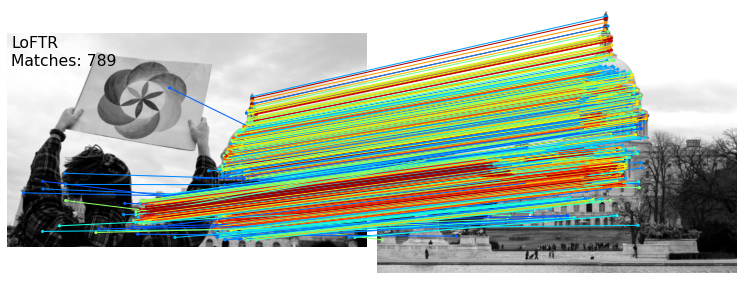

In [8]:
# Draw
if model_type == "opt":
    print(mconf.max())
    mconf = (mconf - min(20.0, mconf.min())) / (max(30.0, mconf.max()) - min(20.0, mconf.min()))

color = cm.jet(mconf)
text = [
    "LoFTR",
    "Matches: {}".format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)